# PBO against LQR
## Define environment

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


max_discrete_state = 7
env = LinearQuadraticEnv(max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = 8.53s + 0.48a
Reward: Qs² + Ra² + 2 Ssa
Reward: -7.61s² + 0.07a² + 6.26sa


## Data collection

In [2]:
from pbo.data_collection.replay_buffer import ReplayBuffer


max_discrete_action = 9
n_samples = 100
epsilon_greedy = 0.7
max_episode_length = 4

replay_buffer = ReplayBuffer()

state = env.reset()
idx_sample = 0
epidose_length = 0

while idx_sample < n_samples:
    if np.random.random() < epsilon_greedy:
        action = env.optimal_action()
    else:
        action = np.random.uniform(-max_discrete_action, max_discrete_action, size=1)
    next_state, reward, _, _ = env.step(action)

    replay_buffer.add(state, action, np.array([reward]), next_state)

    epidose_length += 1
    idx_sample += 1

    if epidose_length >= max_episode_length:
        state = env.reset()
        epidose_length = 0
    else:    
        state = next_state


## Visualize samples

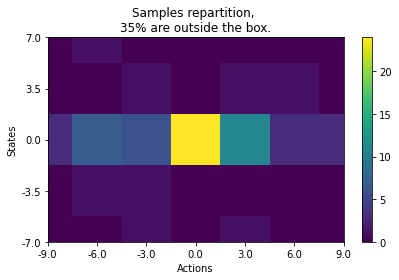

In [3]:
from pbo.data_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


n_discrete_states = 5
n_discrete_actions = 7

samples_count, n_outside_boxes = count_samples(
    replay_buffer, max_discrete_state, n_discrete_states, max_discrete_action, n_discrete_actions
)
samples_visualization_mesh = StateActionMesh(
    max_discrete_state, n_discrete_states, max_discrete_action, n_discrete_actions, sleeping_time=0
)

samples_visualization_mesh.set_values(samples_count)
samples_visualization_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


In [4]:
from pbo.data_collection.dataloader import DataLoader


batch_size = 8
    
replay_buffer.cast_to_tensor()
data_loader = DataLoader(replay_buffer, batch_size)

## Building networks

In [5]:
from pbo.networks.torch.q import QFullyConnectedNet
from pbo.networks.torch.pbo import LinearPBONet

layer_dimension = 3
random_weights_range = 10
gamma = 1

Q_network = QFullyConnectedNet(
    layer_dimension=layer_dimension,
    random_weights_range=random_weights_range,
    max_action=max_discrete_action,
    n_discrete_actions=n_discrete_actions,
)
PBO = LinearPBONet(gamma=gamma, q_weights_dimensions=Q_network.q_weights_dimensions)


## The goal: optimal Q function

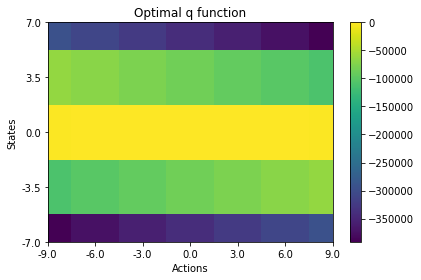

In [6]:
from pbo.utils.compute_Q_lqr import compute_Q_lqr


sleeping_time = 0.4

optimal_Q = compute_Q_lqr(env, max_discrete_state, n_discrete_states, max_discrete_action, n_discrete_actions, gamma)

q_funcions_visualization_mesh = StateActionMesh(max_discrete_state, n_discrete_states, max_discrete_action, n_discrete_actions, sleeping_time)

q_funcions_visualization_mesh.set_values(optimal_Q)
q_funcions_visualization_mesh.show("Optimal q function")

## Training

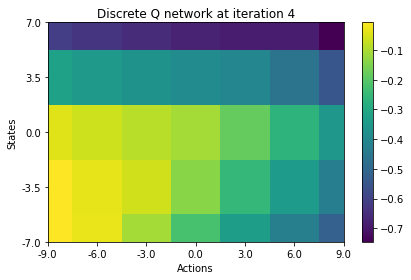

In [9]:
import torch.optim as optim


n_iteration = 5
learning_rate = 0.001
momentum = 0.9

optimizer = optim.SGD(PBO.parameters(), lr=learning_rate, momentum=momentum)

for iteration in range(n_iteration):
    random_weights = Q_network.get_random_weights()

    for batch in data_loader:
        optimizer.zero_grad()
        
        loss = PBO.loss(batch, random_weights, Q_network)
        loss.backward()
        
        optimizer.step()
    
    # Plot the fixed point Q network
    Q_network.set_weights(PBO.get_fixed_point())
    discrete_Q_network = Q_network.get_discrete_Q(max_discrete_state, n_discrete_states)
    
    q_funcions_visualization_mesh.set_values(discrete_Q_network)
    q_funcions_visualization_mesh.show(f"Discrete Q network at iteration {iteration}")
    